# Spaceship titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit

import lazypredict


from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import datasets

from lazypredict.Supervised import LazyClassifier


In [2]:
train = pd.read_csv(r"D:\大三冲刺\数据挖掘\kaggle\data\train.csv")
test = pd.read_csv(r"D:\大三冲刺\数据挖掘\kaggle\data\test.csv")

## Data validation

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [4]:
for i in [train,test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Co

In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [6]:
len(train)

8693

In [7]:
print(train.shape)
print(test.shape)

(8693, 14)
(4277, 13)


In [8]:
train.groupby(by=["Cabin"]).sum()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Cabin,,,,,,,
A/0/P,52.00,0.00,2344.00,0.00,65.00,6898.00,1
A/0/S,91.00,43.00,4859.00,371.00,10044.00,242.00,0
A/1/S,67.00,279.00,605.00,3374.00,286.00,3.00,3
A/10/P,30.00,0.00,3628.00,289.00,1737.00,4987.00,0
A/10/S,20.00,2.00,4754.00,0.00,246.00,31.00,1
...,...,...,...,...,...,...,...
T/0/P,35.00,415.00,1328.00,0.00,14.00,60.00,0
T/1/P,42.00,0.00,1829.00,2.00,3133.00,2447.00,0
T/2/P,33.00,0.00,28.00,0.00,6841.00,543.00,0


### Transform Cabin variable

In [9]:
train[['CabinDeck','CabinNum','CabinSide']] = train['Cabin'].str.split('/', expand=True)
test[['CabinDeck','CabinNum','CabinSide']] = test['Cabin'].str.split('/', expand=True)

In [10]:
train.groupby(by=["CabinDeck"])["PassengerId"].count()

CabinDeck
A     256
B     779
C     747
D     478
E     876
F    2794
G    2559
T       5
Name: PassengerId, dtype: int64

CabinNum
0       18
1       15
10      12
100     12
1000     6
        ..
995      3
996      1
997      2
998      4
999      6
Name: PassengerId, Length: 1817, dtype: int64


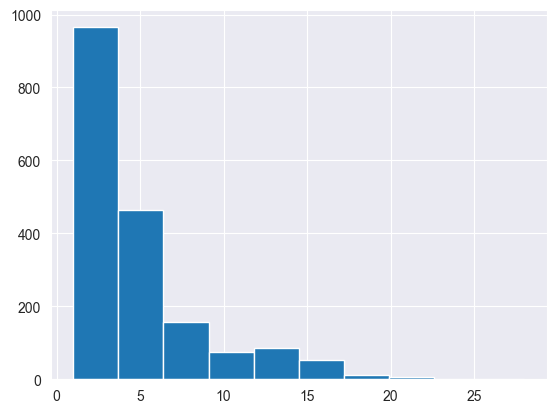

In [11]:
print(train.groupby(by=["CabinNum"])["PassengerId"].count())

plt.hist(train.groupby(by=["CabinNum"])["PassengerId"].count())
plt.show()

train["CabinNum"] = pd.to_numeric(train["CabinNum"])
test["CabinNum"] = pd.to_numeric(test["CabinNum"])

In [12]:
train.groupby(by=["CabinSide"])["PassengerId"].count()

CabinSide
P    4206
S    4288
Name: PassengerId, dtype: int64

In [13]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00,8494.00
mean,28.83,224.69,458.08,173.73,311.14,304.85,600.37
std,14.49,666.72,1611.49,604.70,1136.71,1145.72,511.87
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00,167.25
50%,27.00,0.00,0.00,0.00,0.00,0.00,427.00
75%,38.00,47.00,76.00,27.00,59.00,46.00,999.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,1894.00


### Drop columns

In [14]:
# Drop original cabin column
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

# Drop name column
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

### Detect missing values

In [15]:
d2 = {'nulls': train.isnull().sum(), 'nullratio': train.isnull().sum()/len(train)}
pd.DataFrame(data = d2)

,nulls,nullratio
PassengerId,0,0.00
HomePlanet,201,0.02
CryoSleep,217,0.02
Destination,182,0.02
Age,179,0.02
VIP,203,0.02
RoomService,181,0.02
FoodCourt,183,0.02
ShoppingMall,208,0.02
Spa,183,0.02


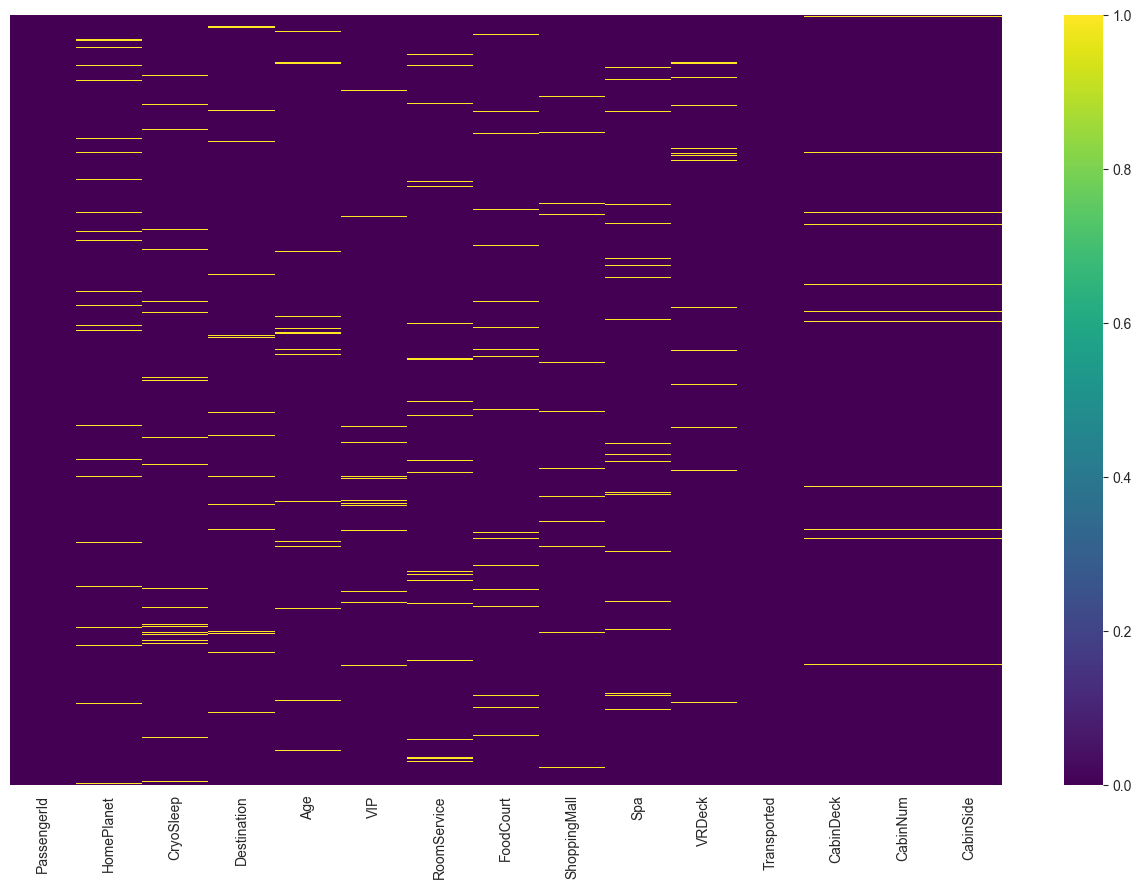

In [16]:
plt.figure(figsize=(16,10))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis')
plt.show()

In [17]:
for column in train.columns:
    print(column + ':', train[column].isnull().sum(), train[column].dtype)

PassengerId: 0 object
HomePlanet: 201 object
CryoSleep: 217 object
Destination: 182 object
Age: 179 float64
VIP: 203 object
RoomService: 181 float64
FoodCourt: 183 float64
ShoppingMall: 208 float64
Spa: 183 float64
VRDeck: 188 float64
Transported: 0 bool
CabinDeck: 199 object
CabinNum: 199 float64
CabinSide: 199 object


### Correlations

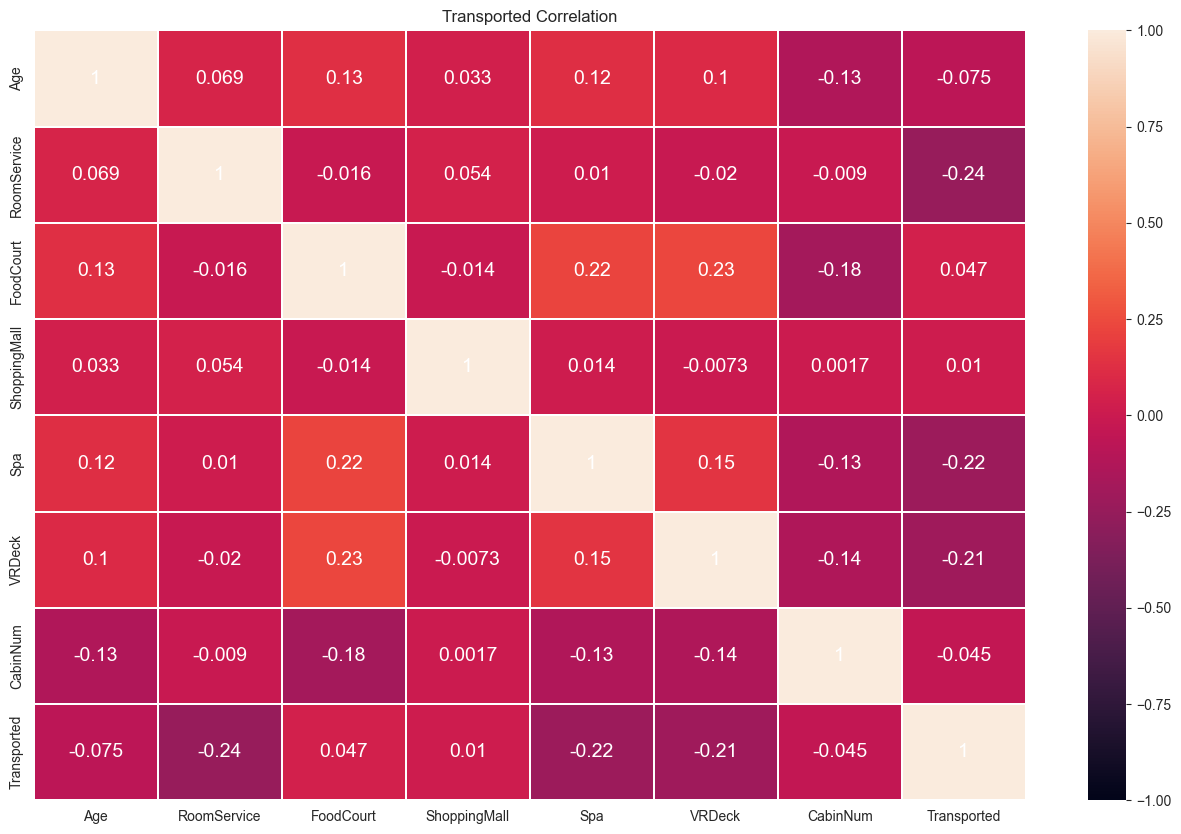

In [18]:
categorical_features = list(train.select_dtypes(include = [object]).columns)
numeric_features = list(train.select_dtypes(include = [np.int64,np.float64]).columns)
boolean_features = list(train.select_dtypes(include = [bool]).columns)

# Heatmap for correlations between numerical variables and the dependent variable
pd.options.display.float_format = "{:,.2f}".format

corr_matrix = train[numeric_features + boolean_features].corr()

plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 14, "color": "white"},annot=True)
plt.title("Transported Correlation")
plt.show()

# The numeric variables don't seem to be correlated too much with the dependent variable

In [19]:
print(numeric_features, categorical_features)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum'] ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']


## Handling missing values

In [20]:
# Filling in missing VIP values with False
train["VIP"].fillna(False, inplace = True)
test["VIP"].fillna(False, inplace = True)

In [21]:
# Filling in missing CryoSleep values with False
train["CryoSleep"].fillna(False, inplace = True)
test["CryoSleep"].fillna(False, inplace = True)

In [22]:
# As all columns with missing values has less than 3% missing, 
# I'm inputing the numerical missing values with the median and the categoricals with the mode

for col in categorical_features:
    train[col].fillna(train[col].mode()[0],inplace = True)
    test[col].fillna(test[col].mode()[0],inplace = True)

for col in numeric_features:
    train[col].fillna(train[col].median(),inplace = True)
    test[col].fillna(test[col].median(),inplace = True)

In [23]:
for i in [train,test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
 12  CabinDeck     8693 non-null   object 
 13  CabinNum      8693 non-null   float64
 14  CabinSide     8693 non-null   object 
dtypes: bool(3), float64(7), object(5)
memory usage: 840.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 

In [24]:
train.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
CabinDeck       0
CabinNum        0
CabinSide       0
dtype: int64

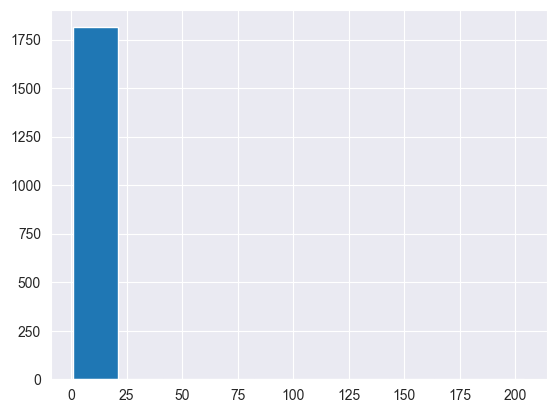

In [25]:
plt.hist(train.groupby(by=["CabinNum"])["PassengerId"].count())
plt.show()

In [26]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum
count,"8,693.00","8,693.00","8,693.00","8,693.00","8,693.00","8,693.00","8,693.00"
mean,28.79,220.01,448.43,169.57,304.59,298.26,596.40
std,14.34,660.52,"1,595.79",598.01,"1,125.56","1,134.13",506.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,20.00,0.00,0.00,0.00,0.00,0.00,173.00
50%,27.00,0.00,0.00,0.00,0.00,0.00,427.00
75%,37.00,41.00,61.00,22.00,53.00,40.00,983.00
max,79.00,"14,327.00","29,813.00","23,492.00","22,408.00","24,133.00","1,894.00"


### Encoding categorical vars

In [27]:
columns_to_encode = ["HomePlanet", "CryoSleep", "Destination", "VIP", "CabinDeck", "CabinSide"]

#le = LabelEncoder()

#for col in columns_to_encode:
#    train[col] = le.fit_transform(train[col])
#    test[col] = le.fit_transform(test[col])

#train_dummified = pd.get_dummies(train, columns = columns_to_encode, drop_first = True)
#test_dummified = pd.get_dummies(test, columns = columns_to_encode, drop_first = True)

ohe = OneHotEncoder(drop = 'first', sparse=False)

ohe.fit(train[columns_to_encode])

OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [28]:
ohe.categories_

[array(['Earth', 'Europa', 'Mars'], dtype=object),
 array([False,  True]),
 array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object),
 array([False,  True]),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype=object),
 array(['P', 'S'], dtype=object)]

In [29]:
train_ohed = pd.DataFrame(ohe.transform(train[columns_to_encode]))
test_ohed = pd.DataFrame(ohe.transform(test[columns_to_encode]))

train_ohed.index = train.index
test_ohed.index = test.index

numeric_train = train.drop(columns_to_encode, axis=1)
numeric_test = test.drop(columns_to_encode, axis=1)

In [30]:
train_ohed = train_ohed.set_axis(['Home Europa', 'Home Mars', 'CryoSleep', 'Dest PSO J318.5-22', \
                    'Dest TRAPPIST-1e', 'VIP', 'Deck B', 'Deck C', 'Deck D', \
                    'Deck E', 'Deck F', 'Deck G', 'Deck T', 'Starboard side'], axis=1, inplace=False)


test_ohed = test_ohed.set_axis(['Home Europa', 'Home Mars', 'CryoSleep', 'Dest PSO J318.5-22', \
                    'Dest TRAPPIST-1e', 'VIP', 'Deck B', 'Deck C', 'Deck D', \
                    'Deck E', 'Deck F', 'Deck G', 'Deck T', 'Starboard side'], axis=1, inplace=False)

In [31]:
new_train = pd.concat([numeric_train, train_ohed], axis=1)
new_test = pd.concat([numeric_test, test_ohed], axis=1)

new_train.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinNum,Home Europa,...,Dest TRAPPIST-1e,VIP,Deck B,Deck C,Deck D,Deck E,Deck F,Deck G,Deck T,Starboard side
0,0001_01,39.00,0.00,0.00,0.00,0.00,0.00,False,0.00,1.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0002_01,24.00,109.00,9.00,25.00,549.00,44.00,True,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
2,0003_01,58.00,43.00,"3,576.00",0.00,"6,715.00",49.00,False,0.00,1.00,...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0003_02,33.00,0.00,"1,283.00",371.00,"3,329.00",193.00,False,0.00,1.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,0004_01,16.00,303.00,70.00,151.00,565.00,2.00,True,1.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


In [32]:
new_test.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,Home Europa,Home Mars,...,Dest TRAPPIST-1e,VIP,Deck B,Deck C,Deck D,Deck E,Deck F,Deck G,Deck T,Starboard side
0,0013_01,27.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
1,0018_01,19.00,0.00,9.00,0.00,"2,823.00",0.00,4.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
2,0019_01,31.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0021_01,38.00,0.00,"6,652.00",0.00,181.00,585.00,1.00,1.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
4,0023_01,20.00,10.00,0.00,635.00,0.00,0.00,5.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


## Model building

### Selecting the best models

In [33]:
X = new_train.drop(['Transported', 'PassengerId'] , axis = 1)
y = new_train['Transported']
X_train , X_test , y_train , y_test = train_test_split(X, 
                                                       y, 
                                                       random_state = 42,
                                                       test_size = 0.33)

In [34]:
clf = LazyClassifier(verbose=0,
                    ignore_warnings=True,
                    custom_metric=None)

models, predictions = clf.fit(X_train , X_test , y_train , y_test)



100%|██████████| 29/29 [00:09<00:00,  2.95it/s]


In [35]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.13
XGBClassifier,0.80,0.80,0.80,0.80,1.56
RandomForestClassifier,0.80,0.80,0.80,0.80,0.61
ExtraTreesClassifier,0.79,0.79,0.79,0.79,0.48
SVC,0.79,0.79,0.79,0.79,0.88
NuSVC,0.79,0.79,0.79,0.79,1.06
LogisticRegression,0.78,0.78,0.78,0.78,0.03
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.24
BaggingClassifier,0.78,0.78,0.78,0.78,0.20


In [36]:
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, StratifiedKFold

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

### Hyperparameter tuning

#### LGBM Classifier

In [53]:
start = timeit.default_timer()

lgbm_clf = LGBMClassifier()

parameters = {
    "learning_rate": sp_randFloat(),
    "max_depth":sp_randInt(4, 10),
    "subsample": sp_randFloat(),
    "n_estimators":sp_randInt(10,1000)
    }

#Evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Random search procedure
random_search = RandomizedSearchCV(estimator = lgbm_clf, param_distributions = parameters, cv = cv, n_iter = 10, n_jobs = -1)

#Executing the random search
random_result = random_search.fit(X_train, y_train)

#Best score and configuration
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_)) 

#Runtime
stop = timeit.default_timer()

print("Hyperparameter tuning runtime:", stop - start)

Best: 0.808955 using {'learning_rate': 0.1450220600914235, 'max_depth': 4, 'n_estimators': 161, 'subsample': 0.3085542196379013}
Hyperparameter tuning runtime: 10.164327399921604


#### XGBoost Classifier

In [38]:
xgb_clf = xgb.XGBClassifier()

#Random search procedure
random_search = RandomizedSearchCV(estimator = xgb_clf, param_distributions = parameters, cv = cv, n_iter = 10, n_jobs = -1)

#Executing the random search
random_result = random_search.fit(X_train, y_train)

#Best score and configuration
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_)) 

#Runtime
stop = timeit.default_timer()

print("Hyperparameter tuning runtime:", stop - start)

Best: 0.801685 using {'learning_rate': 0.09999342956914947, 'max_depth': 5, 'n_estimators': 160, 'subsample': 0.1442727204791714}
Hyperparameter tuning runtime: 97.44990120001603


### Running the models

In [39]:
new_test.shape

(4277, 22)

In [40]:
X_valid = new_test.drop(['PassengerId'], axis = 1)
y_valid = np.empty([4277,], dtype=bool)

In [41]:
lgbm_clf = LGBMClassifier(learning_rate = 0.05112404562350914, 
                            max_depth = 6, 
                            n_estimators = 104, 
                            subsample = 0.7171778425300053,
                            seed = 42)

lgbm_clf.fit(X_train, y_train)

predictions = lgbm_clf.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("Light gradient boosting accuracy: %f" % (accuracy), "\n", \
      "Feature Importances", "\n", pd.DataFrame(zip(X_test.columns, lgbm_clf.feature_importances_)))

lgbm_pred_val = lgbm_clf.predict(X_valid)

Light gradient boosting accuracy: 0.797490 
 Feature Importances 
                      0    1
0                  Age  333
1          RoomService  175
2            FoodCourt  329
3         ShoppingMall  198
4                  Spa  365
5               VRDeck  312
6             CabinNum  467
7          Home Europa   72
8            Home Mars   68
9            CryoSleep   56
10  Dest PSO J318.5-22   14
11    Dest TRAPPIST-1e   64
12                 VIP    3
13              Deck B   22
14              Deck C   88
15              Deck D    3
16              Deck E   77
17              Deck F   41
18              Deck G   57
19              Deck T    0
20      Starboard side  185


In [42]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            learning_rate = 0.012052102010738919, 
                            max_depth = 5, 
                            n_estimators = 647, 
                            subsample = 0.524706494869144,
                            seed = 42)

xgb_clf.fit(X_train, y_train)

predictions = xgb_clf.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("Extreme gradient boosting accuracy: %f" % (accuracy), "\n", \
      "Feature Importances", "\n", pd.DataFrame(zip(X_test.columns, xgb_clf.feature_importances_)))

xgb_pred_val = xgb_clf.predict(X_valid)

Extreme gradient boosting accuracy: 0.799233 
 Feature Importances 
                      0    1
0                  Age 0.02
1          RoomService 0.04
2            FoodCourt 0.03
3         ShoppingMall 0.02
4                  Spa 0.04
5               VRDeck 0.04
6             CabinNum 0.02
7          Home Europa 0.05
8            Home Mars 0.02
9            CryoSleep 0.48
10  Dest PSO J318.5-22 0.01
11    Dest TRAPPIST-1e 0.02
12                 VIP 0.01
13              Deck B 0.02
14              Deck C 0.02
15              Deck D 0.01
16              Deck E 0.03
17              Deck F 0.02
18              Deck G 0.08
19              Deck T 0.00
20      Starboard side 0.03


In [43]:
xgb_pred_val.shape

(4277,)

In [46]:
submission = pd.read_csv("data/sample_submission.csv")

submission["Transported"] = xgb_pred_val.astype('bool')
submission.to_csv("submission.csv", index=False)
submission.head(15)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [54]:
# 'learning_rate': 0.1450220600914235, 'max_depth': 4, 'n_estimators': 161, 'subsample': 0.3085542196379013
best_model = LGBMClassifier(learning_rate = 0.1450220600914235,
                            max_depth = 4,
                            n_estimators = 161,
                            subsample = 0.3085542196379013)
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("Light gradient boosting accuracy: %f" % (accuracy), "\n", \
      "Feature Importances", "\n", pd.DataFrame(zip(X_test.columns, best_model.feature_importances_)))

best_pred_val = best_model.predict(X_valid)

submission = pd.read_csv("data/sample_submission.csv")

submission["Transported"] = best_pred_val.astype('bool')
submission.to_csv("submission.csv", index=False)
submission.head(15)


Light gradient boosting accuracy: 0.803416 
 Feature Importances 
                      0    1
0                  Age  241
1          RoomService  163
2            FoodCourt  207
3         ShoppingMall  175
4                  Spa  224
5               VRDeck  181
6             CabinNum  348
7          Home Europa   21
8            Home Mars   36
9            CryoSleep   29
10  Dest PSO J318.5-22    6
11    Dest TRAPPIST-1e   33
12                 VIP    5
13              Deck B   14
14              Deck C   48
15              Deck D   10
16              Deck E   40
17              Deck F   30
18              Deck G   32
19              Deck T    0
20      Starboard side   94


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [49]:
# 'learning_rate': 0.09999342956914947, 'max_depth': 5, 'n_estimators': 160, 'subsample': 0.1442727204791714
best_model = xgb.XGBClassifier(objective='binary:logistic',
                               learning_rate = 0.09999342956914947,
                               max_depth = 5,
                               n_estimators = 160,
                               subsample = 0.1442727204791714)
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("Extreme gradient boosting accuracy: %f" % (accuracy), "\n", \
      "Feature Importances", "\n", pd.DataFrame(zip(X_test.columns, best_model.feature_importances_)))

best_pred_val = best_model.predict(X_valid)

submission = pd.read_csv("data/sample_submission.csv")

submission["Transported"] = best_pred_val.astype('bool')
submission.to_csv("submission.csv", index=False)
submission.head(15)

Extreme gradient boosting accuracy: 0.788777 
 Feature Importances 
                      0    1
0                  Age 0.03
1          RoomService 0.05
2            FoodCourt 0.04
3         ShoppingMall 0.04
4                  Spa 0.05
5               VRDeck 0.05
6             CabinNum 0.04
7          Home Europa 0.06
8            Home Mars 0.03
9            CryoSleep 0.27
10  Dest PSO J318.5-22 0.03
11    Dest TRAPPIST-1e 0.03
12                 VIP 0.03
13              Deck B 0.03
14              Deck C 0.04
15              Deck D 0.02
16              Deck E 0.04
17              Deck F 0.03
18              Deck G 0.06
19              Deck T 0.00
20      Starboard side 0.04


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
